# Событийная аналитика

Перед нами стоит задача изучить работу стартапа, занимающегося продажей продуктов питания. В исходных данных нам предлагается выгрузка логов с разбивкой пользователей на три группы - 2 контрольные и одну эксперементальную, пользователи которой видят приложение с измененными шрифтами. Нам предстоит изучить поведение пользователей и выяснить, как на это поведение влияет изменение шрифтов в приложении.
<br> Сначала посмотрим на исходные данные о логах в приложении, проверим, нет ли пропусков или аномальных значений. 
<br> Потом проследим путь пользователя от первого посещения до покупки - проверим, какая доля пользователей доходит до каждого шага, где "отваливается" больше всего пользователей. 
<br> После изучим результат проведенного A/A/B-теста и проверим состоятельность выдвинутых гипотез.

## Загрузка библиотек и исходных данных

Для начала выгрузим необходимые библиотеки и установим настройки отображения таблиц

In [1]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from matplotlib.pyplot import figure
from matplotlib import font_manager as fm
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

Загрузим исходные данные (вырианты для просмотра локально и через браузер)

In [2]:
try:
    data = pd.read_csv('logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

## Предобработка данных

Посмотрим на исходные данные

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Перед нами данные о логах в приложении. Датасет содержит информацию о названиях событий, идентификаторе пользователя, дате и времени события в формате timestamp и коде группы, в которую попал пользователь.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Переименуем столбцы

In [5]:
data = data.rename(
    columns={
        'EventName' : 'event_name',
        'DeviceIDHash' : 'user_id',
        'EventTimestamp' : 'event_time',
        'ExpId' : 'exp_id'
    }
)

Поменяем тип данных для времени события

In [6]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

Проверим, есть ли в датафрейме полностью дублированные строки 

In [7]:
data.duplicated().sum()

413

Найдено 413 дубликатов. Нужно их удалить

In [8]:
data = data.drop_duplicates().reset_index(drop=True)

In [9]:
data.event_name.unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

В датасете фиксируется 5 типов событий - "зашел на главную страницу", "обучение", "зашел на страницу с товарами", "зашел в корзину", "успешная оплата". Аномалий или пропусков в столбце нет.
<br>
<br> Посмотрим на столбец с идентификаторами пользователей

In [10]:
display(data.user_id.describe())
display(data.user_id.nunique())

count    2.437130e+05
mean     4.627963e+18
std      2.642723e+18
min      6.888747e+15
25%      2.372212e+18
50%      4.623192e+18
75%      6.932517e+18
max      9.222603e+18
Name: user_id, dtype: float64

7551

Данные однородны, пропусков или нетипичных значений нет. В логах содержится информация о 7551 пользователе.
Посмотрим, сколько событий приходится на одного пользователя.

In [11]:
events_per_user = data.groupby('user_id')['event_name'].count().reset_index()
events_per_user.describe()

,user_id,event_name
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


В среднем на одного пользователя приходится 32 события. Вполне достаточно, чтобы сделать несколько покупок. Рекорд - 2307 действий. 75% пользователей совершили 37 действий или менее.
<br>
<br> Посмотрим на данные

In [12]:
display(data.event_time.min())
display(data.event_time.max())

Timestamp('2019-07-25 04:43:36')

Timestamp('2019-08-07 21:15:17')

В нашем распоряжении данные с 25 июля 2019 по 7 августа 2019

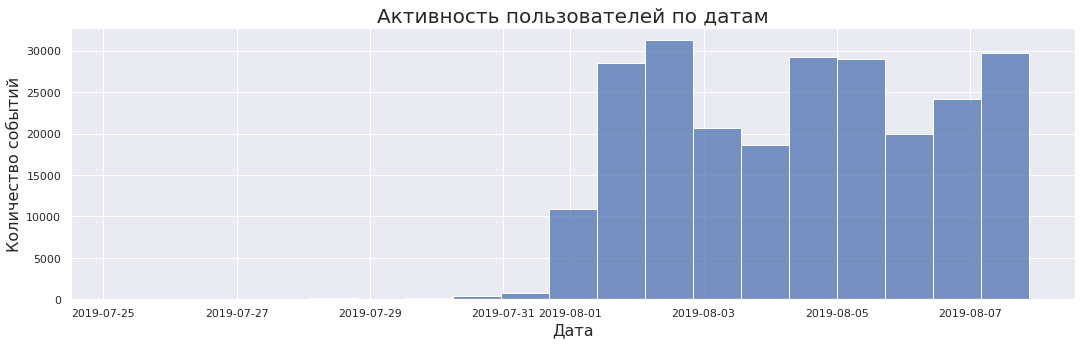

In [13]:
sns.set(rc={'figure.figsize':(18, 5)})
sns.histplot(data=data['event_time'], bins=19)
plt.ylabel('Количество событий', fontsize=16)
plt.xlabel('Дата', fontsize=16)
plt.title('Активность пользователей по датам', fontsize=20)
plt.show()

На графике видно, что основная активность начинается с 1 августа. Более ранние данные можно удалить.

In [14]:
data1 = data[data['event_time'] < '2019-08-01 00:00:00']
data = data[data['event_time'] >= '2019-08-01 00:00:00']

In [15]:
display(data1['event_name'].count())
display(7551 - data['user_id'].nunique())

2826

17

После отсечения части периода мы потеряли почти 2826 записей о логах и 17 уникальных клиентов
<br>
<br> Еще раз посмотрим на пользователей-рекордсменов, делающих большое количество активностей.

In [16]:
champions = data.groupby('user_id')['event_name'].count().reset_index().query('event_name > 1000')
champions

,user_id,event_name
146,197027893265565660,1996
1390,1754140665440434215,1221
2637,3337471580007169353,1186
3707,4623191541214045580,1768
5107,6304868067479728361,2307
5580,6932517045703054087,1439


Пользователи, сделавшие более 1000 переходов за неделю вызывают подозрение. Уберем их из выборки.

In [17]:
data = data.loc[~data.user_id.isin(champions['user_id'])]

Посмотрим на разделение по группам

In [18]:
data.exp_id.unique()

array([246, 247, 248])

Как и заявлено, в датасете 3 группы. Проверим, что у нас нет пользователей, которые попадают больше, чем в одну группу.

In [19]:
data.groupby('user_id')['exp_id'].nunique().reset_index().query('exp_id > 1')

,user_id,exp_id


Траффик организован правильно. 
<br> Посмотрим, сколько пользователей попадают в каждую группу

In [20]:
data.groupby('exp_id')['user_id'].nunique().reset_index()

,exp_id,user_id
0,246,2482
1,247,2511
2,248,2535


Пользователи распределены относительно равномерно. 

In [21]:
a = 244126 - data['event_name'].count()

display(f"В результате предобработки утрачено {7551 - data['user_id'].nunique()} уникальных пользователей")
display(f"В результате предобработки утрачено {a} строк. Это {a*100/244126:.0f}% всех данных")

'В результате предобработки утрачено 23 уникальных пользователей'

'В результате предобработки утрачено 13156 строк. Это 5% всех данных'

Данные проверены. В процессе предобработки мы переименовали столбцы, поменяли формат даты, удалили строки-дубликаты, убрали из выборки часть периода с низкой активностью и подозрительно активных пользователей. В процессе предобработки мы потеряли порядка 5% данных. Теперь можно изучать воронку событий

## Изучение воронки событий

Для того, чтобы понять, сколько пользователей доходят до совершения покупки и что им мешает по дороге, нам нужно изучить воронку событий. Для начала посмотрим, сколько событий каждого типа содержат наши данные.

In [22]:
events_per_type = data.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
events_per_type.columns = ['event_name','event_count']
events_per_type

,event_name,event_count
1,MainScreenAppear,116919
2,OffersScreenAppear,45382
0,CartScreenAppear,37954
3,PaymentScreenSuccessful,29710
4,Tutorial,1005


Больше всего пользователей заходят на главную страницу. Далее - по убыванию - каталог - корзина - страница с оплатой. Выглядит логично. Меньше всего активностей связано с обучением (1018 переходов). Посмотрим, сколько уникальных пользователей совершают каждый шаг.

In [23]:
users_per_type = data.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
users_per_type.columns = ['event_name','unique_users']
users_per_type

,event_name,unique_users
1,MainScreenAppear,7413
2,OffersScreenAppear,4587
0,CartScreenAppear,3728
3,PaymentScreenSuccessful,3533
4,Tutorial,840


Из таблицы видно, что не все пользователи заходят на главную страницу (после того, как мы отсекли часть периода и убрали подозрительно активных, у нас осталось 7528 пользователей), а некоторые проходят обучение более одного раза. Можно предположить, что пользователи попадают в каталог, минуя главную страницу, например, из рассылки. Проверим, есть ли пользователи, открывшие каталог, но ни разу не заходившие на главную страницу.

In [24]:
main_screen_users = data['user_id'][data['event_name'] == 'MainScreenAppear']
offer_screen_users = data['user_id'][data['event_name'] == 'OffersScreenAppear']

offer_not_main_screen_users = offer_screen_users.loc[~offer_screen_users.isin(main_screen_users)]
offer_not_main_screen_users.nunique()

111

111 человек попали в каталог, минуя главную страницу.
<br>
<br> Проверим, есть ли те, кто попал в корзину, но не заходил в каталог

In [25]:
cart_screen_users = data['user_id'][data['event_name'] == 'CartScreenAppear']
cart_not_offer_screen_users = cart_screen_users.loc[~cart_screen_users.isin(offer_screen_users)]
cart_not_offer_screen_users.nunique()

55

И такие нашлись! Скорее всего, ссылка на корзину есть на главной странице. Посмотрим, есть ли те, кто оплатил, не заходя в корзину

In [26]:
payment_screen_users = data['user_id'][data['event_name'] == 'PaymentScreenSuccessful']
payment_not_cart_screen_users = payment_screen_users.loc[~payment_screen_users.isin(cart_screen_users)]
payment_not_cart_screen_users

14658     2842450591691869422
18096     2546485934419825851
18424     3626993001520930273
89415     5624421956850672353
115930    4518329927200442683
Name: user_id, dtype: int64

Стоит уточнить, откуда берутся такие пользователи. Пока предположим, что они покупали товар через менеджера и получили ссылку на оплату по почте.
<br>
<br> В качестве воронки представим все типы активностей, кроме обучения. Для начала посмотрим, какая доля пользователей переходит на каждый уровень воронки.

In [27]:
def count_funnel(events_per_type, users_per_type, total_users):
    funnel = events_per_type.merge(users_per_type, on='event_name', how='inner')
    funnel = funnel[funnel['event_name'] != 'Tutorial']
    funnel['next_level_share'] = funnel['unique_users']/total_users
    funnel['next_level_diff'] = 1 + funnel['next_level_share'].pct_change()
    return funnel

In [28]:
total_users = data['user_id'].nunique()

funnel = count_funnel(events_per_type, users_per_type, total_users)
funnel

,event_name,event_count,unique_users,next_level_share,next_level_diff
0,MainScreenAppear,116919,7413,0.984724,NaN
1,OffersScreenAppear,45382,4587,0.609325,0.618778
2,CartScreenAppear,37954,3728,0.495218,0.812732
3,PaymentScreenSuccessful,29710,3533,0.469315,0.947693


Получается, что 47% пользователей доходят до совершения покупки. Впечатляющий результат! Среди тех, кто сложил товары в корзину, плачивают покупки почти 95%. Кажется, наш сервис работает исправно. Больше всего пользователей "отваливаются" при переходе с главной страницы в каталог. 
<br>
<br> Построим график, чтобы визуализировать данные

In [29]:
def vis_funnel(x_max, title):
    
    #x_max - максимальное значение x на оси
    #title - название графика
    
    #зададим переменные, которые не будут меняться от графика к графику
    x = funnel['unique_users'] #значение ширины элемента воронки
    y = [4,3,2,1] #количество уровней воронки
    labels = funnel['event_name'] #названия уровней воронки
    x_min = 0 #минимальное значение на оси x
    x_range = x_max - x_min #разница между минимальным и максимальным значениями на оси x

    fig, ax = plt.subplots(1, figsize=(12,6)) 
    for idx, val in enumerate(x):
        left = (x_range - val)/2 #определим положение каждого уровня
        plt.barh(y[idx], x[idx], left = left, color='#309B96', height=.8) #зададим параметры столбца
        
        plt.text(x_max/2, y[idx]+0.1, labels[idx], ha='center', fontsize=16, color='white') #зададим параметры названия столбца
        
        plt.text(x_max/2, y[idx]-0.3, x[idx], ha='center', fontsize=16, color='white') #зададим параметры значения столбца
    
    plt.xlim(x_min, x_max)
    plt.axis('off')
    plt.title(title, loc='center', fontsize=24)
    plt.show()

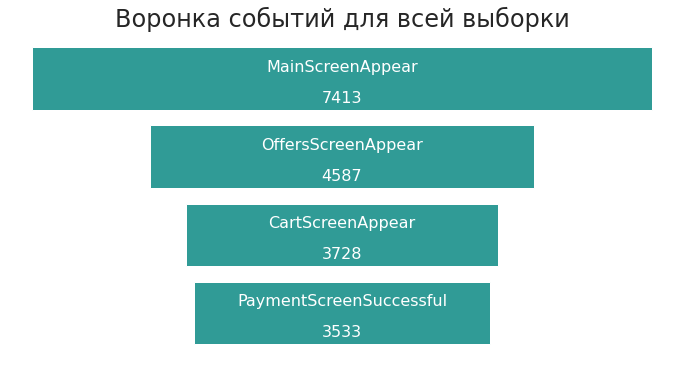

In [30]:
x_max = 8000
title = 'Воронка событий для всей выборки'

vis_funnel(x_max, title)

Самое большое различие между количеством пользователей, открывших главную страницу и теми, кто перешел в каталог. Наименьшее различие между зашедшими на страницу корзины и теми, кто успешно оплатил заказ.
<br>
<br>Посмотрим отдельно на воронку для первой контрольной группы.

In [31]:
data_246 = data[data['exp_id'] == 246]
total_users = data_246['user_id'].nunique()
events_per_type = data_246.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
events_per_type.columns = ['event_name','event_count']
users_per_type = data_246.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
users_per_type.columns = ['event_name','unique_users']
funnel = count_funnel(events_per_type, users_per_type, total_users)
funnel

,event_name,event_count,unique_users,next_level_share,next_level_diff
0,MainScreenAppear,37526,2448,0.986301,NaN
1,OffersScreenAppear,14583,1540,0.620467,0.629085
2,CartScreenAppear,13232,1264,0.509267,0.820779
3,PaymentScreenSuccessful,10462,1198,0.482675,0.947785


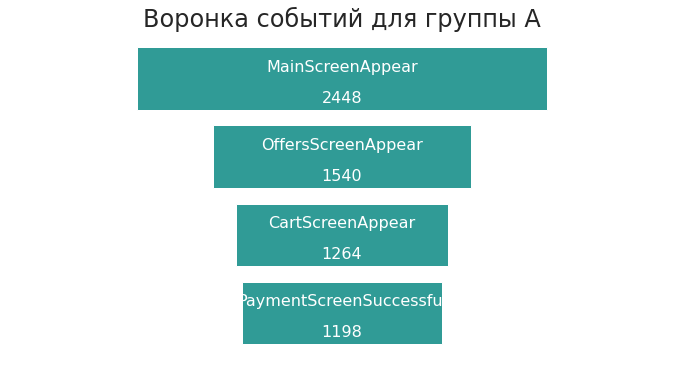

In [32]:
x_max = 4000
title = 'Воронка событий для группы A'

vis_funnel(x_max, title)

В группе А распределение очень похоже на распределение в полной выборке. Самое значительное уменьшение пользователей наблюдается при переходе с главной страницы на страницу с товарами.
<br>
<br> Посмотрим на воронку в группе A1

In [33]:
data_247 = data[data['exp_id'] == 247]
total_users = data_247['user_id'].nunique()
events_per_type = data_247.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
events_per_type.columns = ['event_name','event_count']
users_per_type = data_247.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
users_per_type.columns = ['event_name','unique_users']
funnel = count_funnel(events_per_type, users_per_type, total_users)
funnel

,event_name,event_count,unique_users,next_level_share,next_level_diff
0,MainScreenAppear,38989,2474,0.985265,NaN
1,OffersScreenAppear,14997,1518,0.604540,0.613581
2,CartScreenAppear,11060,1236,0.492234,0.814229
3,PaymentScreenSuccessful,8649,1156,0.460374,0.935275


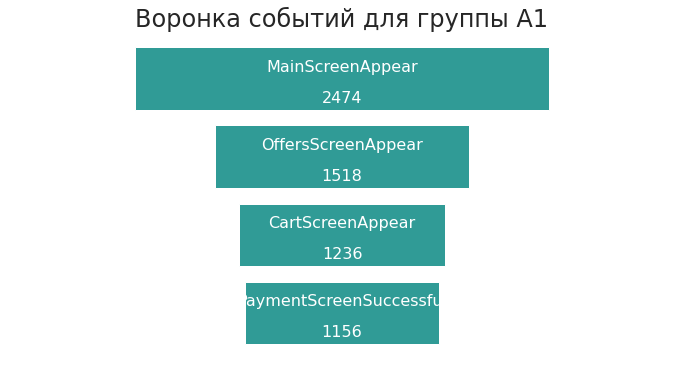

In [34]:
x_max = 4000
title = 'Воронка событий для группы A1'

vis_funnel(x_max, title)

Поведение пользователей в группе A1 похоже на поведение пользователей группы А. Можем предположить, что на группы не влияют аномальные выбросы и траффик распределен корректно.

In [35]:
data_248 = data[data['exp_id'] == 248]
total_users = data_248['user_id'].nunique()
events_per_type = data_248.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
events_per_type.columns = ['event_name','event_count']
users_per_type = data_248.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
users_per_type.columns = ['event_name','unique_users']
funnel = count_funnel(events_per_type, users_per_type, total_users)
funnel

,event_name,event_count,unique_users,next_level_share,next_level_diff
0,MainScreenAppear,40404,2491,0.982643,NaN
1,OffersScreenAppear,15802,1529,0.603156,0.613810
2,CartScreenAppear,13662,1228,0.484418,0.803139
3,PaymentScreenSuccessful,10599,1179,0.465089,0.960098


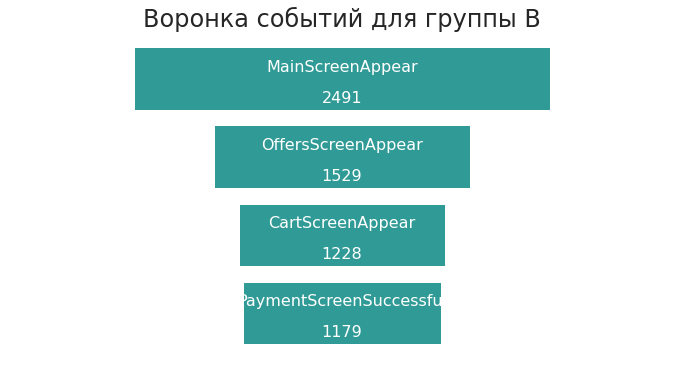

In [36]:
x_max = 4000
title = 'Воронка событий для группы B'

vis_funnel(x_max, title)

Поведение пользователей в контрольной группе исходя из воронки событий также очень похоже. Также, как и в других группах, шагом, где теряется больше всего посетителей, является переход с главной страницы в каталог.
<br>
<br> Исходя из полученных данных, можно предположить, что посетители в трех группах ведут себя примерно одинаково. Стоит проверить это передположение на статистических тестах.

## Изучение результата эксперимента

Теперь проверим, как показали себя наши группы и выясним, как влияет на активность пользователей изменение шрифта в приложении.
<br> Поскольку у нас есть данные о размерах групп и доле пользователей, которые совершили определенные действия, логично использовать z-test и делать проверку гипотезы о равенстве долей. Значение статистической значимости примем на уровне 0.05

In [37]:
data.groupby('exp_id')['user_id'].nunique().reset_index()

,exp_id,user_id
0,246,2482
1,247,2511
2,248,2535


В каждой группе в районе 2500 пользователей. Проверим, есть ли статистические отличия в контрольных группах.
<br>
<br> Для начала подготовим данные о долях пользователей, перешедших на следующую страницу. Для проверки будем использовать следующую логику: Сначала пользователь заходит на главную страницу, потом открывает каталог, переходит в корзину, а затем - на страницу успешной оплаты товара. Если в момент оплаты происходит сбой, он идет на страницу с обучением, чтобы разобраться, что пошло не так.
<br> Сначала сравним две контрольные группы, чтобы убедиться, что между ними нет существенных различий и на результат эксперимента не влияет ничего, кроме изменения шрифтов в приложении. Проведем сравнение для каждого типа события в выборке. 
<br>
<br> Сформулиреум нулевую и альтернативную гипотезы для каждого типа события:

In [38]:
A_unique_users = data[data['exp_id'] == 246]['user_id'].nunique() #общее количество пользователей группы А
A1_unique_users = data[data['exp_id'] == 247]['user_id'].nunique() #общее количество пользователей группы А1
B_unique_users = data[data['exp_id'] == 248]['user_id'].nunique() #общее количество пользователей группы B

groups = (data.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique')
          .reset_index()
          .sort_values(by=246, ascending=False) #группируем данные по типу события
          )
groups['246_share'] = groups[246]/A_unique_users #считаем долю переходов для группы A
groups['247_share'] = groups[247]/A1_unique_users #считаем долю переходов для группы A1
groups['248_share'] = groups[246]/B_unique_users #считаем долю переходов для группы B
groups['246+247'] = (groups[246] + groups[247])#считаем суммарное количество уникальных пользователей групп A и A1
groups['246+247_sahre'] = (groups[246] + groups[247])/(A_unique_users + A1_unique_users) #считаем долю переходов для групп A и A1

groups

exp_id,event_name,246,247,248,246_share,247_share,248_share,246+247,246+247_sahre
1,MainScreenAppear,2448,2474,2491,0.986301,0.985265,0.965680,4922,0.985780
2,OffersScreenAppear,1540,1518,1529,0.620467,0.604540,0.607495,3058,0.612457
0,CartScreenAppear,1264,1236,1228,0.509267,0.492234,0.498619,2500,0.500701
3,PaymentScreenSuccessful,1198,1156,1179,0.482675,0.460374,0.472584,2354,0.471460
4,Tutorial,278,283,279,0.112006,0.112704,0.109665,561,0.112357


In [39]:
for i in range(len(groups.event_name.values.tolist())):
    print('H0: Нет различий между долей пользователей, перешедших на страницу', groups.event_name.values.tolist()[i], 'в группе А и в группе А1')
    print('H1: Доля пользователей, перешедших на страницу', groups.event_name.values.tolist()[i], 'в группе А существенно отличается от доли в группе А1')
    print()

H0: Нет различий между долей пользователей, перешедших на страницу MainScreenAppear в группе А и в группе А1
H1: Доля пользователей, перешедших на страницу MainScreenAppear в группе А существенно отличается от доли в группе А1

H0: Нет различий между долей пользователей, перешедших на страницу OffersScreenAppear в группе А и в группе А1
H1: Доля пользователей, перешедших на страницу OffersScreenAppear в группе А существенно отличается от доли в группе А1

H0: Нет различий между долей пользователей, перешедших на страницу CartScreenAppear в группе А и в группе А1
H1: Доля пользователей, перешедших на страницу CartScreenAppear в группе А существенно отличается от доли в группе А1

H0: Нет различий между долей пользователей, перешедших на страницу PaymentScreenSuccessful в группе А и в группе А1
H1: Доля пользователей, перешедших на страницу PaymentScreenSuccessful в группе А существенно отличается от доли в группе А1

H0: Нет различий между долей пользователей, перешедших на страницу Tut

In [40]:
def z_test_check(group_1, group_2, group_1_size, group_2_size, alpha): #задаем формулу для расчета p-value по z-тесту
    for i in range(len(groups.event_name.values.tolist())): #определяем длинну цикла по количеству типов событий
        count = np.array([group_1[i], group_2[i]]) #задаем значения сравниваемых долей
        nobs = np.array([group_1_size, group_2_size]) #задаем значения сравниваемых размеров выборок
        value = alpha #задаем уровень значимости
        stat, pval = proportions_ztest(count, nobs) #считаем p-value
        print('p-value сравнения страниц', groups.event_name.values.tolist()[i] , '{0:0.3f}'.format(pval)) #выводим результат


In [41]:
z_test_check(groups[246], groups[247], A_unique_users, A1_unique_users, .05)

p-value сравнения страниц MainScreenAppear 0.229
p-value сравнения страниц OffersScreenAppear 0.757
p-value сравнения страниц CartScreenAppear 0.248
p-value сравнения страниц PaymentScreenSuccessful 0.114
p-value сравнения страниц Tutorial 0.938


p-value в замерах для каждой страницы во всех случаях больше уровня статистической значимости. В случае с переходам на страницу Tutorial p-value стремится к единице. Значит, у нас не получиллось опровергнуть нулевую гипотезу о том, что выборки равны. Можно считать, что между контрольными выборками нет статистически значимых различий,  и мы можем сравнивать их с эксперементальной выборкой.
<br>
<br> Сформулируем нулевые и альтернативные гипотезы для сравнение контрольной группы А с эскперементальной B

In [42]:
for i in range(len(groups.event_name.values.tolist())):
    print('H0: Нет различий между долей пользователей, перешедших на страницу', groups.event_name.values.tolist()[i], 'в группе А и в группе B')
    print('H1: Доля пользователей, перешедших на страницу', groups.event_name.values.tolist()[i], 'в группе А существенно отличается от доли в группе B')
    print()

H0: Нет различий между долей пользователей, перешедших на страницу MainScreenAppear в группе А и в группе B
H1: Доля пользователей, перешедших на страницу MainScreenAppear в группе А существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу OffersScreenAppear в группе А и в группе B
H1: Доля пользователей, перешедших на страницу OffersScreenAppear в группе А существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу CartScreenAppear в группе А и в группе B
H1: Доля пользователей, перешедших на страницу CartScreenAppear в группе А существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу PaymentScreenSuccessful в группе А и в группе B
H1: Доля пользователей, перешедших на страницу PaymentScreenSuccessful в группе А существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу Tutorial в 

In [43]:
z_test_check(groups[246], groups[248], A_unique_users, B_unique_users, .05)

p-value сравнения страниц MainScreenAppear 0.078
p-value сравнения страниц OffersScreenAppear 0.295
p-value сравнения страниц CartScreenAppear 0.208
p-value сравнения страниц PaymentScreenSuccessful 0.212
p-value сравнения страниц Tutorial 0.826


Все значения p-value также больше уровня статистической значимости, но для страниц MainScreenAppear значение p-value опасно приближается к заданному альфа. Тем не менее, опровергнуть нулевую гипотезу не получилось. Существенных различий между группами A и B не обнаружено.
<br>
<br> Сформулируем нулевые и альтернативные гипотезы для сравнение контрольной группы А1 с эскперементальной B

In [44]:
for i in range(len(groups.event_name.values.tolist())):
    print('H0: Нет различий между долей пользователей, перешедших на страницу', groups.event_name.values.tolist()[i], 'в группе А1 и в группе B')
    print('H1: Доля пользователей, перешедших на страницу', groups.event_name.values.tolist()[i], 'в группе А1 существенно отличается от доли в группе B')
    print()

H0: Нет различий между долей пользователей, перешедших на страницу MainScreenAppear в группе А1 и в группе B
H1: Доля пользователей, перешедших на страницу MainScreenAppear в группе А1 существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу OffersScreenAppear в группе А1 и в группе B
H1: Доля пользователей, перешедших на страницу OffersScreenAppear в группе А1 существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу CartScreenAppear в группе А1 и в группе B
H1: Доля пользователей, перешедших на страницу CartScreenAppear в группе А1 существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу PaymentScreenSuccessful в группе А1 и в группе B
H1: Доля пользователей, перешедших на страницу PaymentScreenSuccessful в группе А1 существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу Tut

In [45]:
z_test_check(groups[247], groups[248], A1_unique_users, B_unique_users, .05)

p-value сравнения страниц MainScreenAppear 0.579
p-value сравнения страниц OffersScreenAppear 0.459
p-value сравнения страниц CartScreenAppear 0.920
p-value сравнения страниц PaymentScreenSuccessful 0.737
p-value сравнения страниц Tutorial 0.765


В сравнении групп A1 и B p-value больше, чем в предыдущем сравнении. Все значения значительно выше уровня статистической значимости, а p-value в выборках по пользователям, перешедшим в корзину стремится к единице. Опровергнуть нулевую гипотезу не получится и можно предположить, что между выборками нет статистически значимых различий.
<br>
<br> Сформулируем нулевые и альтернативные гипотезы для сравнение объединенной контрольной группы А+А1 с эскперементальной B

In [46]:
for i in range(len(groups.event_name.values.tolist())):
    print('H0: Нет различий между долей пользователей, перешедших на страницу', groups.event_name.values.tolist()[i], 'в группе А+A1 и в группе B')
    print('H1: Доля пользователей, перешедших на страницу', groups.event_name.values.tolist()[i], 'в группе А+A1 существенно отличается от доли в группе B')
    print()

H0: Нет различий между долей пользователей, перешедших на страницу MainScreenAppear в группе А+A1 и в группе B
H1: Доля пользователей, перешедших на страницу MainScreenAppear в группе А+A1 существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу OffersScreenAppear в группе А+A1 и в группе B
H1: Доля пользователей, перешедших на страницу OffersScreenAppear в группе А+A1 существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу CartScreenAppear в группе А+A1 и в группе B
H1: Доля пользователей, перешедших на страницу CartScreenAppear в группе А+A1 существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших на страницу PaymentScreenSuccessful в группе А+A1 и в группе B
H1: Доля пользователей, перешедших на страницу PaymentScreenSuccessful в группе А+A1 существенно отличается от доли в группе B

H0: Нет различий между долей пользователей, перешедших

In [47]:
z_test_check(groups['246+247'], groups[248], A_unique_users + A1_unique_users, B_unique_users, .05)

p-value сравнения страниц MainScreenAppear 0.182
p-value сравнения страниц OffersScreenAppear 0.294
p-value сравнения страниц CartScreenAppear 0.434
p-value сравнения страниц PaymentScreenSuccessful 0.601
p-value сравнения страниц Tutorial 0.765


Результаты сравнения эксперементальной группы с объединенной контрольной группой также находятся в пределах заданного уровня статистической значимости. То есть, и в этих расчетах не получилось опровергнуть нулевую гипотезу, и статистически значимых различий между выборками нет.

## Вывод

Мы изучили выгрузку логов работы приложения, обнаружили в ней дубликаты и аномально активных пользователей, нормализовали данные, построили воронки событий для всей выборки и для каждой группы.
<br> Больше всего пользователей заходят на главную страницу, меньше всего - на обучающую страницу.
<br> Наибольшие потери в количестве пользователей происходят при переходе с главной страницы в каталог. 
<br> Меньше всего пользователей уходит при переходе от корзины к странице успешной оплаты товаров. 
<br> Существуют клиенты, которые не пользуются стандартным маршрутом Главная - Каталог - Корзина - Успешная оплата, а попадают на страницы, не побывав на предыдущем уровне. Стоит изучить такие случаи и найти им объяснения.
<br>
<br> z-тесты сравнения долей пользователей, переходивших на разные страницы в контрольных и эксперементальной группах не выявили статистически значимых различий между группами. 
<br> Наибольшее сходство наблюдается в поведении пользователей, переходящих на страницу с обучением, наименьший результат p-value зафиксирован для пользователей, переходящих на главную страницу. 
<br> Между группами A1 и B обнаружено больше сходства, чем между двумя контрольными группами A и A1. 
<br> Изменение шрифта приложения не повлияло на поведение пользователей и можно вводить новый внешний вид приложения для всех. С другой стороны, если нет никакой разницы, зачем проводить трудоемкие изменения? Оставим этот вопрос для обсуждения всей командой.